#  Statistical Relational Learning with `pslpython`

Can we build a PSL model for *link prediction* to evaluate the annotations in a friend graph?

In [1]:
from pslpython.model import Model
from pslpython.partition import Partition
from pslpython.predicate import Predicate
from pslpython.rule import Rule

model = Model("simple acquaintances")

# add predicates
predicate = Predicate("Knows", closed=False, size=2)
model.add_predicate(predicate)

predicate = Predicate("Likes", closed=True, size=2)
model.add_predicate(predicate)

predicate = Predicate("Neighbors", closed=True, size=2)
model.add_predicate(predicate)

In [2]:
# add rules
model.add_rule(Rule("20: Neighbors(P1, L) & Neighbors(P2, L) & (P1 != P2) -> Knows(P1, P2) ^2"))
model.add_rule(Rule("5: Neighbors(P1, L1) & Neighbors(P2, L2) & (P1 != P2) & (L1 != L2) -> !Knows(P1, P2) ^2"))

model.add_rule(Rule("10: Likes(P1, L) & Likes(P2, L) & (P1 != P2) -> Knows(P1, P2) ^2"))

model.add_rule(Rule("5: Knows(P1, P2) & Knows(P2, P3) & (P1 != P3) -> Knows(P1, P3) ^2"))
model.add_rule(Rule("5: !Knows(P1, P2) ^2"))

model.add_rule(Rule("Knows(P1, P2) = Knows(P2, P1) ."))

In [3]:
DATA_DIR = "dat/psl/"

acq = {}

files = [
    "lived_obs.txt",
    "likes_obs.txt",
    "knows_obs.txt",
    "knows_targets.txt",
    "knows_truth.txt",
]

for filename in files:
    col_name = filename.split(".")[0]

    with open(DATA_DIR + filename, "r") as f:
        for line in f:
            row = line.strip().split("\t")
            p1, p2 = row[0:2]
            pair = (p1, p2,)
            
            if len(row) == 3:
                weight = float(row[2])
            else:
                weight = 1.0
        
            if pair not in acq:
                acq[pair] = {}

            acq[pair][col_name] = float(weight)

sorted(acq.items())

[(('0', '0'), {'likes_obs': 0.5792357761763203}),
 (('0', '1'),
  {'likes_obs': 0.8034665712301672, 'knows_targets': 1.0, 'knows_truth': 1.0}),
 (('0', '10'), {'knows_obs': 1.0}),
 (('0', '11'), {'knows_obs': 1.0}),
 (('0', '12'), {'knows_obs': 1.0}),
 (('0', '13'), {'knows_obs': 1.0}),
 (('0', '14'), {'knows_obs': 1.0}),
 (('0', '15'), {'knows_targets': 1.0, 'knows_truth': 1.0}),
 (('0', '16'), {'knows_obs': 1.0}),
 (('0', '17'), {'knows_obs': 1.0}),
 (('0', '18'), {'knows_targets': 1.0, 'knows_truth': 1.0}),
 (('0', '19'), {'knows_obs': 0.0}),
 (('0', '2'), {'likes_obs': 0.6194292469435183, 'knows_obs': 1.0}),
 (('0', '20'), {'knows_obs': 0.0}),
 (('0', '21'), {'knows_obs': 1.0}),
 (('0', '22'), {'knows_targets': 1.0, 'knows_truth': 0.0}),
 (('0', '23'), {'knows_obs': 1.0}),
 (('0', '24'), {'knows_obs': 1.0}),
 (('0', '3'), {'likes_obs': 0.17649495639106194, 'knows_obs': 1.0}),
 (('0', '4'),
  {'lived_obs': 1.0, 'likes_obs': 0.8060242892584343, 'knows_obs': 1.0}),
 (('0', '5'), {'lik

In [4]:
import pandas as pd

row_list = []
columns = ["p1", "p2", "lived_obs", "likes_obs", "knows_obs", "knows_truth", "knows_targets"]

for key, val in acq.items():
    p1, p2 = key
    val["p1"] = p1
    val["p2"] = p2
    row_list.append(val)

df = pd.DataFrame(row_list, columns=columns)
df

,p1,p2,lived_obs,likes_obs,knows_obs,knows_truth,knows_targets
0,0,4,1.0,0.806024,1.0,NaN,NaN
1,1,0,1.0,0.682753,1.0,NaN,NaN
2,1,4,1.0,0.455612,1.0,NaN,NaN
3,2,2,1.0,0.409688,NaN,NaN,NaN
4,2,4,1.0,0.775959,1.0,NaN,NaN
...,...,...,...,...,...,...,...
605,21,22,NaN,NaN,NaN,1.0,1.0
606,21,24,NaN,NaN,NaN,0.0,1.0
607,22,21,NaN,NaN,NaN,1.0,1.0
608,22,24,NaN,NaN,NaN,1.0,1.0


In [5]:
float(round(0.41))

0.0

In [19]:
# add data
for predicate in model.get_predicates().values():
    predicate.clear_data()

predicate = model.get_predicate("Neighbors")

with open(DATA_DIR + "lived_obs.txt", "r") as f:
    for line in f:
        row = line.strip().split("\t")
        p1, p2 = row[0:2]
        predicate.add_data_row(Partition.OBSERVATIONS, [p1, p2])
        #print(":person_{} acq:neighbors :person_{} .".format(p1, p2))

predicate = model.get_predicate("Likes")

with open(DATA_DIR + "likes_obs.txt", "r") as f:
    for line in f:
        row = line.strip().split("\t")
        p1, p2 = row[0:2]
        truth = float(row[2])
        truth = float(round(truth))
        predicate.add_data_row(Partition.OBSERVATIONS, [p1, p2], truth_value=truth)
        
        if truth < 0.5:
            print("acq:person_{} acq:dislikes acq:person_{} .".format(p1, p2))

predicate = model.get_predicate("Knows")

with open(DATA_DIR + "knows_obs.txt", "r") as f:
    for line in f:
        row = line.strip().split("\t")
        p1, p2 = row[0:2]
        truth = float(row[2])
        predicate.add_data_row(Partition.OBSERVATIONS, [p1, p2], truth_value=truth)

        if truth < 0.5:
            print("acq:person_{} acq:wantsIntro acq:person_{} .".format(p1, p2))

with open(DATA_DIR + "knows_truth.txt", "r") as f:
    for line in f:
        row = line.strip().split("\t")
        p1, p2 = row[0:2]
        truth = float(row[2])
        predicate.add_data_row(Partition.TRUTH, [p1, p2], truth_value=truth)

with open(DATA_DIR + "knows_targets.txt", "r") as f:
    for line in f:
        row = line.strip().split("\t")
        p1, p2 = row[0:2]
        predicate.add_data_row(Partition.TARGETS, [p1, p2])

acq:person_0 acq:dislikes acq:person_3 .
acq:person_1 acq:dislikes acq:person_2 .
acq:person_1 acq:dislikes acq:person_3 .
acq:person_1 acq:dislikes acq:person_4 .
acq:person_2 acq:dislikes acq:person_2 .
acq:person_3 acq:dislikes acq:person_2 .
acq:person_4 acq:dislikes acq:person_4 .
acq:person_5 acq:dislikes acq:person_0 .
acq:person_5 acq:dislikes acq:person_3 .
acq:person_6 acq:dislikes acq:person_0 .
acq:person_6 acq:dislikes acq:person_2 .
acq:person_6 acq:dislikes acq:person_3 .
acq:person_6 acq:dislikes acq:person_4 .
acq:person_7 acq:dislikes acq:person_2 .
acq:person_7 acq:dislikes acq:person_3 .
acq:person_8 acq:dislikes acq:person_0 .
acq:person_8 acq:dislikes acq:person_4 .
acq:person_9 acq:dislikes acq:person_1 .
acq:person_9 acq:dislikes acq:person_2 .
acq:person_9 acq:dislikes acq:person_4 .
acq:person_10 acq:dislikes acq:person_3 .
acq:person_10 acq:dislikes acq:person_4 .
acq:person_11 acq:dislikes acq:person_1 .
acq:person_11 acq:dislikes acq:person_2 .
acq:person_1

In [7]:
# inference

PSL_OPTIONS = {
    "log4j.threshold": "INFO"
}

results = model.infer(additional_cli_optons=[], psl_config=PSL_OPTIONS)

3751 [pslpython.model PSL] INFO --- 0    [main] INFO  org.linqs.psl.cli.Launcher  - Running PSL CLI Version 2.2.2-5f9a472
4172 [pslpython.model PSL] INFO --- 423  [main] INFO  org.linqs.psl.cli.Launcher  - Loading data
4408 [pslpython.model PSL] INFO --- 659  [main] INFO  org.linqs.psl.cli.Launcher  - Data loading complete
4409 [pslpython.model PSL] INFO --- 659  [main] INFO  org.linqs.psl.cli.Launcher  - Loading model from /var/folders/zz/2ffrqd5j7n52x67qd94h_r_h0000gp/T/psl-python/simple acquaintances/simple acquaintances.psl
4551 [pslpython.model PSL] INFO --- 802  [main] INFO  org.linqs.psl.cli.Launcher  - Model loading complete
4552 [pslpython.model PSL] INFO --- 802  [main] INFO  org.linqs.psl.cli.Launcher  - Starting inference with class: org.linqs.psl.application.inference.MPEInference
4665 [pslpython.model PSL] INFO --- 916  [main] INFO  org.linqs.psl.application.inference.MPEInference  - Grounding out model.
5088 [pslpython.model PSL] INFO --- 1339 [main] INFO  org.linqs.psl.

In [8]:
# report results
predicate = model.get_predicates()["KNOWS"]
df = results[predicate]

df

,0,1,truth
0,7,20,0.002162
1,8,13,0.997966
2,8,12,0.995318
3,8,10,0.996838
4,8,21,0.997977
...,...,...,...
113,5,9,0.503016
114,5,7,0.502949
115,6,7,0.996754
116,6,9,0.606497


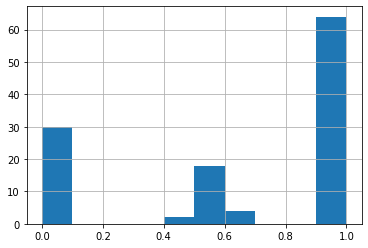

In [9]:
df["truth"].hist()

In [30]:
import kglab

namespaces = {
    "acq": "http://example.org/stuff/",
    "foaf": "http://xmlns.com/foaf/0.1/",
    "rdfs": "http://www.w3.org/2000/01/rdf-schema#",
    }

kg = kglab.KnowledgeGraph(
    name = "LINQS simple acquaintance example for PSL",
    base_uri = "http://example.org/stuff/",
    language = "en",
    namespaces = namespaces,
    )

kg.load_ttl("acq.ttl")

In [31]:
for s, p, o in kg._g:
    print(s, p, o.n3())

http://example.org/stuff/person_2 http://xmlns.com/foaf/0.1/knows <http://example.org/stuff/person_4>
http://example.org/stuff/person_21 http://example.org/stuff/likes <http://example.org/stuff/person_1>
http://example.org/stuff/person_1 http://xmlns.com/foaf/0.1/knows <http://example.org/stuff/person_19>
http://example.org/stuff/person_6 http://xmlns.com/foaf/0.1/knows <http://example.org/stuff/person_11>
http://example.org/stuff/person_24 http://xmlns.com/foaf/0.1/knows <http://example.org/stuff/person_15>
http://example.org/stuff/person_10 http://xmlns.com/foaf/0.1/knows <http://example.org/stuff/person_22>
http://example.org/stuff/person_11 http://xmlns.com/foaf/0.1/knows <http://example.org/stuff/person_13>
http://example.org/stuff/person_9 http://example.org/stuff/likes <http://example.org/stuff/person_3>
http://example.org/stuff/person_10 http://xmlns.com/foaf/0.1/knows <http://example.org/stuff/person_16>
http://example.org/stuff/person_6 http://xmlns.com/foaf/0.1/knows <http:/

In [32]:
VIS_STYLE = {
    "foaf": {
        "color": "orange",
        "size": 5,
    },
    "acq":{
        "color": "blue",
        "size": 30,
    },
}

g = kg.vis_pyvis(notebook=True, style=VIS_STYLE)
g.barnes_hut()
g.show("tmp.html")

In [24]:
kg.save_ttl("foo.ttl")

In [26]:
query = """
SELECT ?p1 ?p2
  WHERE {
      ?p1 foaf:topic_interest acq:Poker .
      ?p2 foaf:topic_interest acq:Poker .
      ?p1 foaf:knows ?p2 .
  }
        """

for row in kg.query(query):
    p1 = row[0].replace("http://example.org/stuff/person_", "")
    p2 = row[1].replace("http://example.org/stuff/person_", "")
    print("TARGET: Knows {} {}".format(p1, p2))

TARGET: Knows 23 14
TARGET: Knows 23 20
TARGET: Knows 23 0
TARGET: Knows 23 7
TARGET: Knows 23 3
TARGET: Knows 23 21
TARGET: Knows 23 5
TARGET: Knows 23 15
TARGET: Knows 23 13
TARGET: Knows 23 10
TARGET: Knows 23 2
TARGET: Knows 23 1
TARGET: Knows 23 9
TARGET: Knows 12 14
TARGET: Knows 12 20
TARGET: Knows 12 0
TARGET: Knows 12 7
TARGET: Knows 12 18
TARGET: Knows 12 3
TARGET: Knows 12 21
TARGET: Knows 12 5
TARGET: Knows 12 11
TARGET: Knows 12 6
TARGET: Knows 12 4
TARGET: Knows 12 8
TARGET: Knows 12 10
TARGET: Knows 12 2
TARGET: Knows 12 1
TARGET: Knows 12 9
TARGET: Knows 14 23
TARGET: Knows 14 12
TARGET: Knows 14 20
TARGET: Knows 14 0
TARGET: Knows 14 7
TARGET: Knows 14 22
TARGET: Knows 14 3
TARGET: Knows 14 11
TARGET: Knows 14 15
TARGET: Knows 14 19
TARGET: Knows 14 8
TARGET: Knows 14 13
TARGET: Knows 14 10
TARGET: Knows 14 1
TARGET: Knows 14 9
TARGET: Knows 20 23
TARGET: Knows 20 12
TARGET: Knows 20 14
TARGET: Knows 20 18
TARGET: Knows 20 22
TARGET: Knows 20 3
TARGET: Knows 20 21
TARG

In [29]:
list(range(0, 25))

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24]